# Mini Project Deep Learning (Training)
Notebook By. Afif A. Iskandar

## Membuat klasifier citra untuk kasus MotoGP

- Kelompok : OAOE; Kelompok 3 
- TA : Bahrul
- Anggota : 
    * Ziyad
    * Stezar
    * Faisal
    * Nella
    * Nourma

## Melatih CNN

In [1]:
# import library yang dibutuhkan
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from neural_net.myneuralnets import MyNeuralNets
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os
import pickle
import matplotlib

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath

In [22]:
# Definisikan path dataset dan tempat menyimpan model
dataset = 'dataset/' # tempat menyimpan dataset
model_path = 'model/model_motogp31.h5'# tempat menyimpan model
labelbin = 'label/motogp31.pkl' # tempat menyimpan encodedlabel


In [23]:
#  hyperparameter
EPOCHS = 30
INIT_LR = 1e-3 # learning rate
BS = 10 # batch
IMAGE_DIMS = (96, 96, 3) # size gambar untuk resize

In [24]:
IMAGE_DIMS[2]

3

In [25]:
# inisialisasi list data dan label
data = []
labels = []

# load gambar dan acak untuk train + test
imagePaths = sorted(list(list_images(dataset)))
random.seed(42)
random.shuffle(imagePaths)

In [26]:
# loop pada dataset untuk simpan data dan label
for imagePath in imagePaths:
    image = load_img(imagePath, target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # ekstrak label
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label.split('/')[1])

In [27]:
# Normalisasi data
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matriks: {:2f}MB".format(
    data.nbytes/ (1024 * 1000.0)))


[INFO] data matriks: 100.440000MB


In [29]:
# binarisasi label
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [30]:
# train-test-split data dan labels 
# UBAH KODE INI
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.33, random_state=123)

In [31]:
# konstruksi ImageGenerator
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [32]:
# inisialisasi model
print("[INFO] Mengcompile Jaringan")
model = MyNeuralNets.build(width=IMAGE_DIMS[1], 
    height=IMAGE_DIMS[0], depth=IMAGE_DIMS[2], 
    classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# UBAH BAGIAN INI
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] Mengcompile Jaringan


In [34]:
from keras.callbacks import ModelCheckpoint

In [35]:
# latih jaringan
print("[INFO] Melatih Jaringan")
filepath = 'motogp-bobot-epoch{epoch:02d}-akurasi-{val_acc:.2f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1,
    callbacks=callbacks_list)

[INFO] Melatih Jaringan
Epoch 1/30
31/31 [==============================] - 8s 263ms/step - loss: 1.8238 - acc: 0.2002 - val_loss: 1.7793 - val_acc: 0.2597

Epoch 00001: val_acc improved from -inf to 0.25974, saving model to motogp-bobot-epoch01-akurasi-0.26.h5
Epoch 2/30
31/31 [==============================] - 8s 247ms/step - loss: 1.7518 - acc: 0.2099 - val_loss: 1.5855 - val_acc: 0.3247

Epoch 00002: val_acc improved from 0.25974 to 0.32468, saving model to motogp-bobot-epoch02-akurasi-0.32.h5
Epoch 3/30
31/31 [==============================] - 8s 252ms/step - loss: 1.4875 - acc: 0.3326 - val_loss: 1.4510 - val_acc: 0.3117

Epoch 00003: val_acc did not improve from 0.32468
Epoch 4/30
31/31 [==============================] - 8s 261ms/step - loss: 1.4018 - acc: 0.3487 - val_loss: 1.2993 - val_acc: 0.3636

Epoch 00004: val_acc improved from 0.32468 to 0.36364, saving model to motogp-bobot-epoch04-akurasi-0.36.h5
Epoch 5/30
31/31 [==============================] - 8s 245ms/step - loss:

In [36]:
# menyimpan model
print("[INFO] Menyimpan Model Kedalam Disk")
model.save(model_path)

[INFO] Menyimpan Model Kedalam Disk


In [37]:
# menyimpan label binary
print("[INFO] Menyimpan Label Binary")
f = open(labelbin, 'wb')
f.write(pickle.dumps(lb))
f.close()

[INFO] Menyimpan Label Binary


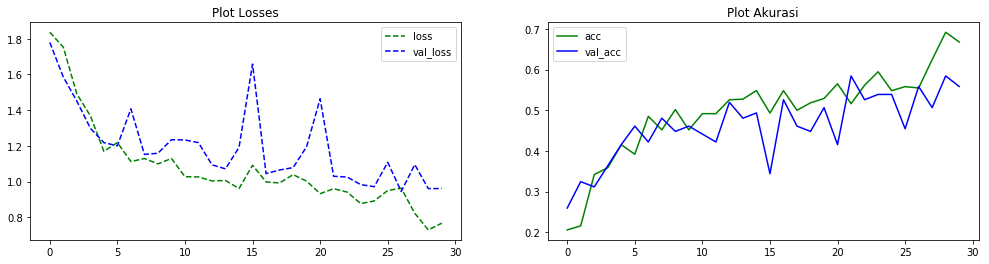

In [38]:
# plot akurasi dan loss
# history dapat diakses dari variabel "H"

x_ticks = H.epoch
history = H.history
plt.figure(figsize=(17,4))
plt.subplot(1,2,1)
plt.title('Plot Losses')
plt.plot(x_ticks, history['loss'], label="loss", ls='--',color='g')
plt.plot(x_ticks, history['val_loss'], label="val_loss", ls='--',color='b')
plt.legend()
plt.subplot(1,2,2)
plt.title('Plot Akurasi')
plt.plot(x_ticks, history['acc'], label="acc",color='g')
plt.plot(x_ticks, history['val_acc'], label="val_acc",color='b')
plt.legend()
plt.show()